In [3]:
import os
import glob
import sys
import getpass
import importlib
from tqdm import tqdm
from pathlib import Path

# user path:
usrname = getpass.getuser()
# add paths:
sys.path.append(f'/Users/{usrname}/Desktop/Projects')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/bimanual_wrist')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/Functional_Fusion')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/PcmPy')


import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns

import scipy.stats as stats
import scipy
import scipy.io as sio
import numpy as np
import pandas as pd

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')



The contra and ipsi representations could be orthogonal, parallel, or something in between. How can we model and test this? Here we can simulate different situations and see how different models work

For the within-hand structure, we'll pick the model that best predicted the data. For the between contra and ipsi, we will consider different situations and will model them.

# Orthogonal representation

the contra and ipsi activity patterns are orthogonal to each other. 

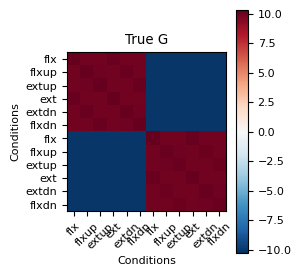

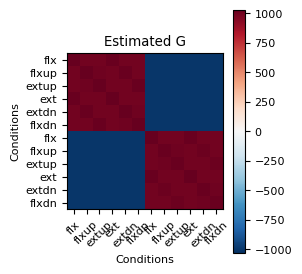

In [69]:
region = 'M1'
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn', 'flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
signal = 100
n_sim = 1000
rng = np.random.default_rng(seed=2)

# load the within hand structure model:
file_path = os.path.join(analysisDir, f'pcm_Ghat_best_within_model_{region}.npz')
data = np.load(file_path)
G_mdl = data['G_hat']
G_mdl = G_mdl / np.trace(G_mdl)

# build the true G:
ncond = 12

G_hand = np.zeros((ncond, ncond))
G_hand[0:6,0:6] = 1
G_hand[6:12,6:12] = 1
G_hand = pcm.centering(ncond) @ G_hand @ pcm.centering(ncond)

G_contra = np.zeros((ncond, ncond))
G_contra[0:6,0:6] = G_mdl

G_ipsi = np.zeros((ncond, ncond))
G_ipsi[6:12,6:12] = G_mdl

M = pcm.ComponentModel('orth', [G_hand, G_contra, G_ipsi])
theta_true = np.array([3, 0.4, 0.1])
G_true, _ = M.predict(theta_true)

# visualize the true G:
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(3,3))
vmin = -np.max(np.abs(G_true))
vmax = np.max(np.abs(G_true))
plt.imshow(G_true, cmap='RdBu_r', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('True G')
plt.xlabel('Conditions')
plt.ylabel('Conditions')
plt.xticks(ticks=np.arange(ncond), labels=labels, rotation=45)
plt.yticks(ticks=np.arange(ncond), labels=labels)
plt.tight_layout()
plt.show()

# data model:
M = pcm.model.FixedModel('orth', G_true)

cond_vec, part_vec = pcm.sim.make_design(n_cond=12, n_part=10)
D = pcm.sim.make_dataset(model=M, 
    theta=theta_true, 
    cond_vec=cond_vec, 
    part_vec=part_vec, 
    n_sim=n_sim, 
    n_channel=300,
    signal=signal,
    rng=rng)

# data g matrix:
N = len(D)
G_hat = np.zeros((N, ncond, ncond))
Dist = np.zeros((N,ncond,ncond))
for i in range(N):
    G_hat[i, :, :], _ = pcm.est_G_crossval(D[i].measurements,
                                            D[i].obs_descriptors['cond_vec'],
                                            D[i].obs_descriptors['part_vec'],
                                            X=pcm.matrix.indicator(D[i].obs_descriptors['part_vec']))
    Dist[i,:,:] = pcm.G_to_dist(G_hat[i,:,:])

# visualize the estimated G:
G_mean = np.mean(G_hat, axis=0)
plt.figure(figsize=(3,3))
vmin = -np.max(np.abs(G_mean))
vmax = np.max(np.abs(G_mean))
plt.imshow(G_mean, cmap='RdBu_r', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Estimated G')
plt.xlabel('Conditions')
plt.ylabel('Conditions')
plt.xticks(ticks=np.arange(ncond), labels=labels, rotation=45)
plt.yticks(ticks=np.arange(ncond), labels=labels)
plt.tight_layout()
plt.show()



## Component model

### build models

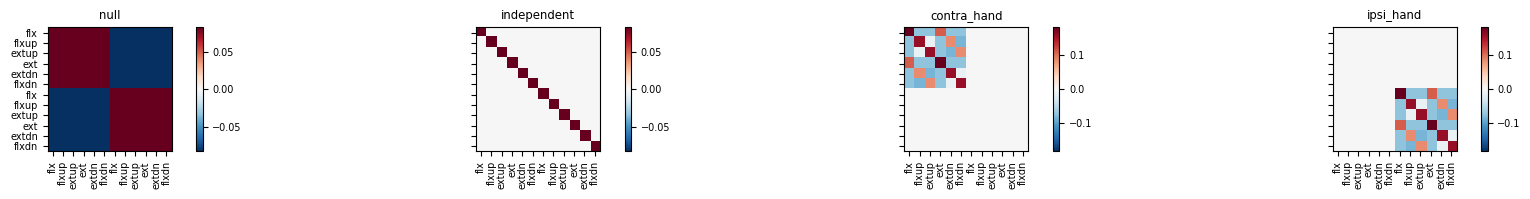

In [81]:
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn', 'flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
ncond = 12
cmap='RdBu_r'

M = []
modelG = {}

# Simple hand model:
cov = np.zeros((ncond, ncond))
cov[0:6, 0:6] = 1
cov = pcm.centering(ncond) @ cov @ pcm.centering(ncond)
cov = cov / np.trace(cov)
modelG['null'] = [cov]
M.append(pcm.FixedModel('null', cov))

# independent:
cov = np.eye(ncond) / ncond
modelG['independent'] = [cov]
# M.append(pcm.FixedModel('independent', cov))

# Best model from unimanual direction encoding:
file_path = os.path.join(analysisDir, f'pcm_Ghat_best_within_model_{region}.npz')
data = np.load(file_path)
G_mdl = data['G_hat']
G_mdl = G_mdl / np.trace(G_mdl)

cov = np.zeros((ncond, ncond))
cov[0:6, 0:6] = G_mdl
# M.append(pcm.FixedModel('contra hand', cov))
modelG['contra_hand'] = [cov]

# Ipsi hand structure:
cov = np.zeros((ncond, ncond))
cov[6:12, 6:12] = G_mdl
# M.append(pcm.FixedModel('ipsi hand', cov))
modelG['ipsi_hand'] = [cov]

# Parallel contra-ipsi:
# cov = np.eye(ncond) / 6
# cov[0:6, 6:12] = G_mdl
# cov[6:12, 0:6] = G_mdl
# # cov = np.tile(G_ceil, (2,2))
# # M.append(pcm.FixedModel('orth translation', cov))
# cov = pcm.centering(ncond) @ cov @ pcm.centering(ncond)
# modelG['parallel'] = [cov]

# component models:
M.append(pcm.ComponentModel('independent', [modelG['null'][0],modelG['independent'][0]]))
M.append(pcm.ComponentModel('orthogonal', [modelG['null'][0],modelG['independent'][0],modelG['contra_hand'][0], modelG['ipsi_hand'][0]]))
# M.append(pcm.ComponentModel('parallel', [modelG['null'][0],modelG['independent'][0],modelG['contra_hand'][0], modelG['ipsi_hand'][0], modelG['parallel'][0]]))

# PLOT:
n = len(modelG)
plt.rcParams.update({'font.size': 7})
fix, ax = plt.subplots(1,n, figsize=(18,2), sharey=True)
for i in range(n):
    vmin = -np.max(np.abs(modelG[list(modelG.keys())[i]]))
    vmax = np.max(np.abs(modelG[list(modelG.keys())[i]]))
    ax[i].imshow(modelG[list(modelG.keys())[i]][0], cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i].set_title(list(modelG.keys())[i])
    ax[i].set_xticks(list(range(12)))
    ax[i].set_xticklabels(labels, rotation=90)
    ax[i].set_yticks(list(range(12)))
    ax[i].set_yticklabels(labels)
    plt.colorbar(ax[i].imshow(modelG[list(modelG.keys())[i]][0], cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i])
plt.tight_layout()
plt.show()




### Fit model

In [82]:
# fit model:
T_gr, theta_gr = pcm.fit_model_group(D, M, fixed_effect='block', fit_scale=True, verbose=True)
T_cv, theta_cv = pcm.fit_model_group_crossval(D, M, fixed_effect='block', fit_scale=True, verbose=True)

results = {
            'T_gr': T_gr, 'theta_gr': theta_gr,
            'T_cv': T_cv, 'theta_cv': theta_cv
            }


Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2


### Plot predictions

[ 3.11285098 -2.85004636 -1.39602163 -1.68928318]


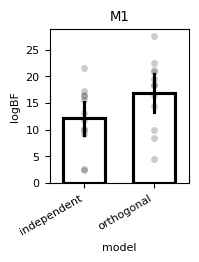

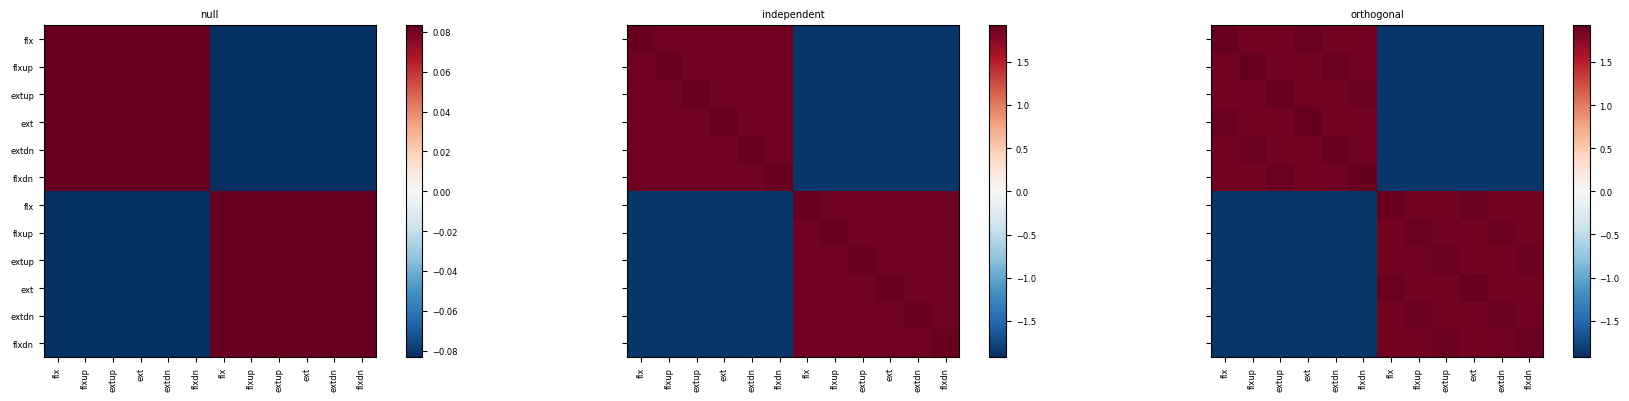

In [ ]:
i = 2
print(f'{theta_gr[i][:M[i].n_param]}')

# set font:
matplotlib.rcParams.update({'font.size': 8})
fig, ax = plt.subplots(1,1,figsize=(1.8,2))
likelihood = T_cv.likelihood
baseline = likelihood.loc[:,'null'].values
likelihood = likelihood - baseline.reshape(-1,1)
LL = likelihood.melt(var_name='model', value_name='logBF')
LL = LL[LL['model'] != 'null']
sns.barplot(data=LL, x='model', y='logBF', ax=ax, fill=False, color='k', width=0.6)
sns.stripplot(data=LL, x='model', y='logBF', ax=ax, color='k', size=5, jitter=False, alpha=0.2)

plt.xticks(rotation=30, ha='right')
plt.title(f'{region}')
plt.show()

nmodels = len(M)
# set font:
matplotlib.rcParams.update({'font.size': 6})
# Plot model predictions:
fig, ax = plt.subplots(1, nmodels, figsize=(18,4), sharey=True)
for i in range(nmodels):
    G = M[i].predict(theta_gr[i][:M[i].n_param])[0]
    vmin = -np.max(np.abs(G))
    vmax = np.max(np.abs(G))
    ax[i].imshow(G, cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i].set_title(M[i].name)
    ax[i].set_xticks(list(range(12)))
    ax[i].set_xticklabels(labels, rotation=90)
    ax[i].set_yticks(list(range(12)))
    ax[i].set_yticklabels(labels)
    plt.colorbar(ax[i].imshow(G, cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i])
plt.tight_layout()
plt.show()





## Correlation model

Similar to Ariani et al 2025. 
First, remove the mean pattern of contralateral and ipsilateral conditions. Then stack the activity patterns of the 6 contralateral conditions into one vector. Same for ipsilateral conditions into another vector. Average the stacked activity patterns across runs. Then correlate the two vectors. Repeat for each subject. This can be tested in two ways: 1- simple Pearson correlated (affected by noise) 2- PCM correlation model

### Simple pearson

Ground Truth r = 0
Mean r: 0.000 +/- 0.001
T-test > 0: t(999) = 0.166, p = 0.434


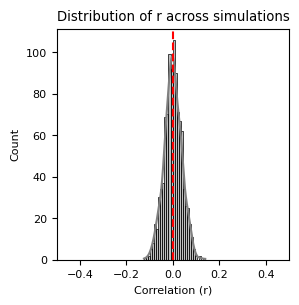

In [ ]:
N = len(D)
r = []
for i in range(N):
    # Average every 10 rows
    # This assumes the rows are ordered by condition, with 10 rows per condition.
    num_conditions = 6
    num_rows_per_condition = 10
    num_voxels = y_contra.shape[1]
    
    # get the contra conditions: 
    y_contra = D[i].measurements[D[i].obs_descriptors['cond_vec'] < 6, :]
    y_contra_avg = y_contra.reshape(num_conditions, num_rows_per_condition, num_voxels).mean(axis=1)
    # remove mean across conditions:
    y_contra_avg = y_contra_avg - y_contra_avg.mean(axis=0)
    # flatten the averaged patterns:
    y_contra_vec = y_contra_avg.flatten()
    
    # get the ipsi conditions:
    y_ipsi = D[i].measurements[D[i].obs_descriptors['cond_vec'] >= 6, :]
    y_ipsi_avg = y_ipsi.reshape(num_conditions, num_rows_per_condition, num_voxels).mean(axis=1)
    # remove mean across conditions:
    y_ipsi_avg = y_ipsi_avg - y_ipsi_avg.mean(axis=0)
    # flatten the averaged patterns:
    y_ipsi_vec = y_ipsi_avg.flatten()

    # concatenate the contra and ipsi patterns:
    r.append(np.corrcoef(y_contra_vec, y_ipsi_vec)[0,1])

r = np.array(r)
print('Ground Truth r = 0')
print(f'Mean r: {np.mean(r):.3f} +/- {stats.sem(r):.3f}')

# t-test > 0:
t_stat, p_val = stats.ttest_1samp(r, 0, alternative='greater')
print(f'T-test > 0: t({N-1}) = {t_stat:.3f}, p = {p_val:.3f}')

# distribution of r:
plt.figure(figsize=(3,3))
sns.histplot(r, bins=30, kde=True, color='gray')
plt.axvline(np.mean(r), color='red', linestyle='--', label='Mean r')
plt.xlabel('Correlation (r)')
plt.ylabel('Count')
plt.title('Distribution of r across simulations')
plt.xlim(-0.5,0.5)
plt.show()




# Intrinsic representation

the contra and ipsi are fully in the same subspace and fully parallel (there is no rotation). Only a simple DC shift has separated them. 

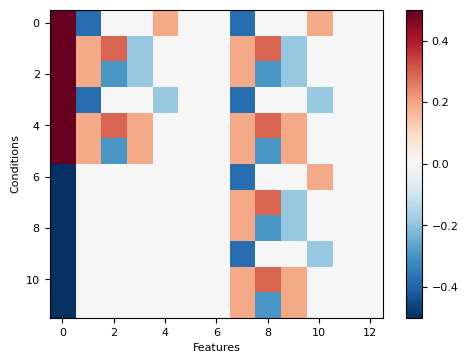

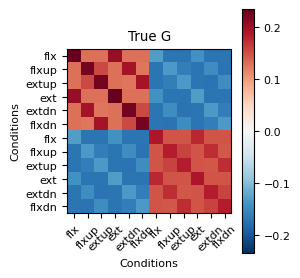

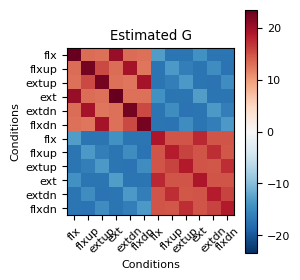

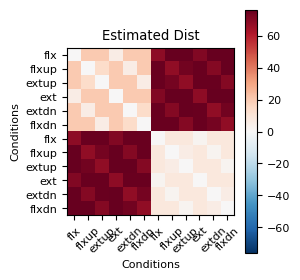

In [64]:
region = 'M1'
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn', 'flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
signal = 100
ncond = 12
nsim = 1000
rng = np.random.default_rng(seed=3)
C = pcm.matrix.centering(12)

# load the within hand structure model:
file_path = os.path.join(analysisDir, f'pcm_Ghat_best_within_model_{region}.npz')
data = np.load(file_path)
G_mdl = data['G_hat']
G_mdl = G_mdl / np.trace(G_mdl)
# decompose G_mdl so that G_mdl = A @ A.T
U, S, Vt = np.linalg.svd(G_mdl)
A = U @ np.sqrt(np.diag(S))

# which hand reached:
F1 = np.zeros((12, 13))
F1[0:6, 0] = 1  # contra
F1[6: , 0] = 0  # ipsi
F1 = C @ F1

# Contralateral hand
F2 = np.zeros((12, 13))
F2[0:6, 1:7] = A
F2 = C @ F2

# Ipsilateral hand
F3 = np.zeros((12, 13))
F3[6: , 7:13] = A
F3 = C @ F3

# interaction:
F4 = np.zeros((12, 13))
F4[0:6, 7:13] = A
F4 = C @ F4

# Make feature model:
A = np.stack([F1, F2, F3, F4], axis=0)
M = pcm.model.FeatureModel('parallel', A)

F = A.sum(axis=0)
plt.figure(figsize=(6,4))
plt.imshow(F, cmap='RdBu_r')
plt.colorbar()
plt.xlabel('Features')
plt.ylabel('Conditions')

theta_true = np.array([0.8, 0.5, 0.4, 0.4])
G_true, _ = M.predict(theta_true)

# visualize the true G:
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(3,3))
vmin = -np.max(np.abs(G_true))
vmax = np.max(np.abs(G_true))
plt.imshow(G_true, cmap='RdBu_r', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('True G')
plt.xlabel('Conditions')
plt.ylabel('Conditions')
plt.xticks(ticks=np.arange(ncond), labels=labels, rotation=45)
plt.yticks(ticks=np.arange(ncond), labels=labels)
plt.tight_layout()
plt.show()

cond_vec, part_vec = pcm.sim.make_design(n_cond=12, n_part=10)
D = pcm.sim.make_dataset(model=M, 
    theta=theta_true, 
    cond_vec=cond_vec, 
    part_vec=part_vec, 
    n_sim=nsim, 
    n_channel = 300,
    signal=signal,
    rng=rng)

# data g matrix:
N = len(D)
G_hat = np.zeros((N, ncond, ncond))
Dist = np.zeros((N,ncond,ncond))
for i in range(N):
    G_hat[i, :, :], _ = pcm.est_G_crossval(D[i].measurements,
                                            D[i].obs_descriptors['cond_vec'],
                                            D[i].obs_descriptors['part_vec'],
                                            X=pcm.matrix.indicator(D[i].obs_descriptors['part_vec']))
    Dist[i,:,:] = pcm.G_to_dist(G_hat[i,:,:])

# visualize the estimated G:
G_mean = np.mean(G_hat, axis=0)
plt.figure(figsize=(3,3))
vmin = -np.max(np.abs(G_mean))
vmax = np.max(np.abs(G_mean))
plt.imshow(G_mean, cmap='RdBu_r', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Estimated G')
plt.xlabel('Conditions')
plt.ylabel('Conditions')
plt.xticks(ticks=np.arange(ncond), labels=labels, rotation=45)
plt.yticks(ticks=np.arange(ncond), labels=labels)
plt.tight_layout()
plt.show()

# visualize estimated Dist:
D_mean = np.mean(Dist, axis=0)
plt.figure(figsize=(3,3))
vmin = -np.max(np.abs(D_mean))
vmax = np.max(np.abs(D_mean))
plt.imshow(D_mean, cmap='RdBu_r', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Estimated Dist')
plt.xlabel('Conditions')
plt.ylabel('Conditions')
plt.xticks(ticks=np.arange(ncond), labels=labels, rotation=45)
plt.yticks(ticks=np.arange(ncond), labels=labels)
plt.tight_layout()
plt.show()




## Correlation model

### Simple Pearson's r

Mean r: 0.250 +/- 0.001
T-test > 0: t(999) = 291.870, p = 0.000


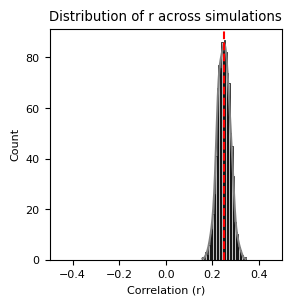

In [68]:
N = len(D)
r = []
for i in range(N):
    # Average every 10 rows
    # This assumes the rows are ordered by condition, with 10 rows per condition.
    num_conditions = 6
    num_rows_per_condition = 10
    num_voxels = D[i].measurements.shape[1]
    
    # get the contra conditions:
    y_contra = D[i].measurements[D[i].obs_descriptors['cond_vec'] < 6, :]
    y_contra = y_contra - y_contra.mean(axis=0)
    y_contra_avg = y_contra.reshape(num_conditions, num_rows_per_condition, num_voxels).mean(axis=1)
    # flatten the averaged patterns:
    y_contra_vec = y_contra_avg.flatten()
    
    # get the ipsi conditions:
    y_ipsi = D[i].measurements[D[i].obs_descriptors['cond_vec'] >= 6, :]
    y_ipsi = y_ipsi - y_ipsi.mean(axis=0)
    y_ipsi_avg = y_ipsi.reshape(num_conditions, num_rows_per_condition, num_voxels).mean(axis=1)
    # flatten the averaged patterns:
    y_ipsi_vec = y_ipsi_avg.flatten()
    
    # concatenate the contra and ipsi patterns:
    r.append(np.corrcoef(y_contra_vec, y_ipsi_vec)[0,1])

r = np.array(r)
print(f'Mean r: {np.mean(r):.3f} +/- {stats.sem(r):.3f}')

# t-test > 0:
t_stat, p_val = stats.ttest_1samp(r, 0, alternative='greater')
print(f'T-test > 0: t({N-1}) = {t_stat:.3f}, p = {p_val:.3f}')

# distribution of r:
plt.figure(figsize=(3,3))
sns.histplot(r, bins=30, kde=True, color='gray')
plt.axvline(np.mean(r), color='red', linestyle='--', label='Mean r')
plt.xlabel('Correlation (r)')
plt.ylabel('Count')
plt.title('Distribution of r across simulations')
plt.xlim(-0.5,0.5)
plt.show()

